In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import covid_model as cm
import population_params as pp
import epi_params as ep

### Epidemiological Parameters

In [4]:
# Basic reproduction number
# If no age stratification: 
# pars["R0"] = pp.population["p"] * ep.pars["Ra"] + (1 - pp.population["p"]) * ep.pars["Rs"]

# With age stratification:
r0 = sum(pp.population["p"] * pp.population["agefrac"] * ep.pars["Ra"] + 
                 (1 - pp.population["p"]) * pp.population["agefrac"] * ep.pars["Rs"])
r0

3.0944655344655354

### Init the population - baseline


In [5]:
tmpzeros = np.zeros(pp.population["nran"])

outbreak = {}
outbreak["y0"] = np.concatenate((pp.population["agefrac"], tmpzeros, tmpzeros,
                                 tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros), axis = None)

# Initiate an outbreak
# Remove one person from the Susceptible population, third age group
# Move that person to the Exposed population, third age group
outbreak["y0"] = pp.population["N"] * outbreak["y0"]
outbreak["y0"][2] = outbreak["y0"][2]-1
outbreak["y0"][12] = 1
outbreak["y0"] = outbreak["y0"]/pp.population["N"]
outbreak["pTime"] = 365
outbreak["pNear"] = 30
outbreak["pshift"] =  0

### Simulation

In [6]:
# From parameter fitting
t0_opt = 67 + 7
te = t0_opt

In [7]:
# Parameter fit approach
sol_pre = solve_ivp(cm.SEIRplus, (0, t0_opt + 1), outbreak["y0"], t_eval = np.arange(0, t0_opt + 1 , 1), \
                    args = (ep.pars, pp.population), reltol = 1e-8, max_step = 0.1)

/labs/csbig/dgarcia-covid/miniconda3/envs/model-covid/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `reltol`.
  warn("The following arguments have no effect for a chosen solver: {}."


 ### Simulate control measures reducing transmission rate for asymptomatic and symptomatic

In [9]:
# Percentage reduction of transmission rate
trans_red = np.array([0, 0.25, 0.5, 0.75])
#From susceptible to asymptomatic exposed. beta_a = transmission for asymptomatic
beta_a = ep.pars["beta_a"] 
#From susceptible to symptomatic exposed. beta_s = transmission for symptomatic
beta_s = ep.pars["beta_s"]

y_vals = []

In [10]:
for tr in trans_red:
    ep.pars["beta_a"] = (1 - tr) * beta_a
    ep.pars["beta_s"] = (1 - tr) * beta_s
    
    sol_pos = solve_ivp(cm.SEIRplus, (0, outbreak["pNear"] + 1) , np.transpose(sol_pre.y)[-1], \
                    t_eval =  np.arange(0, outbreak["pNear"] + 1, 1), \
                    args = (ep.pars, pp.population), reltol = 1e-8, max_step = 0.1)
    y_vals.append(np.vstack((np.transpose(sol_pre.y)[0:-1], np.transpose(sol_pos.y))))

### Stats

In [11]:
stats = {}
# Recovered
stats["R"] = [y[:, pp.population["R_ids"]] for y in y_vals]
# Deaths
stats["D"] = [y[:, pp.population["D_ids"]] for y in y_vals]
# Total hospital care
stats["Htot"] = [y[:, pp.population["Ihsub_ids"]] + y[:, pp.population["Ihcri_ids"]] for y in y_vals]
# Total critical patients
stats["Hacu"] = [y[:, pp.population["Ihcri_ids"]] for y in y_vals]
# New deaths per day per age group
stats["Dday_age"] = [d[1:,:] - d[0:-1,:] for d in stats["D"]]
# New deaths per day 
stats["Dday"] = [sum(np.transpose(d_age)) for d_age in stats["Dday_age"]]
# Cummulative number of deaths
stats["Dcum"] = [sum(np.transpose(d)) for d in stats["D"]]
# Cummulative number of critical patients
stats["Hacu_day"] = [sum(np.transpose(h)) for h in stats["Hacu"]]
# Total of non susceptible
stats["fracI"] = [1 - sum(np.transpose(y[:, pp.population["S_ids"]])) for y in y_vals]
# Total of symptomatics
stats["Is"] = [sum(np.transpose(y[:, pp.population["Is_ids"]])) for y in y_vals]
# New symptomatic cases by day
stats["Iday"] = [s[1:] - s[0:-1] for s in stats["Is"]]
# Symptomatic + subacute + critical
stats["Isevere"] = [sum(np.transpose(y[:, 3*pp.population["nran"]:6*pp.population["nran"] + 1])) \
                    for y in y_vals]

In [12]:
t_vals = np.concatenate((np.arange(0, t0_opt)-te, np.arange(0, outbreak["pNear"] + 1)))
tmpi = np.where(t_vals <= 0)
Htot = [sum(np.transpose(h[tmpi])) for h in stats["Htot"]]

# Plots

In [13]:
import matplotlib.pyplot as plt
import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter

In [14]:
tmpi = np.where(t_vals >= 0)

## Cummulative deaths

In [15]:
Dcum = [d[tmpi] * pp.population["N"] for d in stats["Dcum"]]

day_base = datetime.date.today()
dates = [day_base + datetime.timedelta(days=int(x)) for x in t_vals[tmpi]]       
dates.sort()                                                             

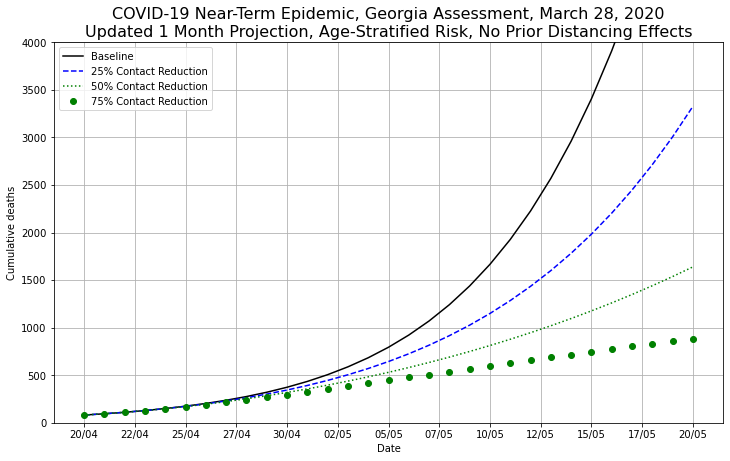

In [16]:
date_form = DateFormatter("%d/%m")

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.plot(dates, Dcum[0], 'k', label = "Baseline")
ax.plot(dates, Dcum[1], 'b--', label = "25% Contact Reduction")
ax.plot(dates, Dcum[2], 'g:', label = "50% Contact Reduction")
ax.plot(dates, Dcum[3], 'go', label = "75% Contact Reduction")
ax.set(xlabel = 'Date', ylabel = 'Cumulative deaths', ylim= (0, 4000))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""COVID-19 Near-Term Epidemic, Georgia Assessment, March 28, 2020
Updated 1 Month Projection, Age-Stratified Risk, No Prior Distancing Effects""")
plt.show()

## ICU beds needed

In [17]:
Hacu = [h[tmpi] * pp.population["N"] for h in stats["Hacu_day"]]

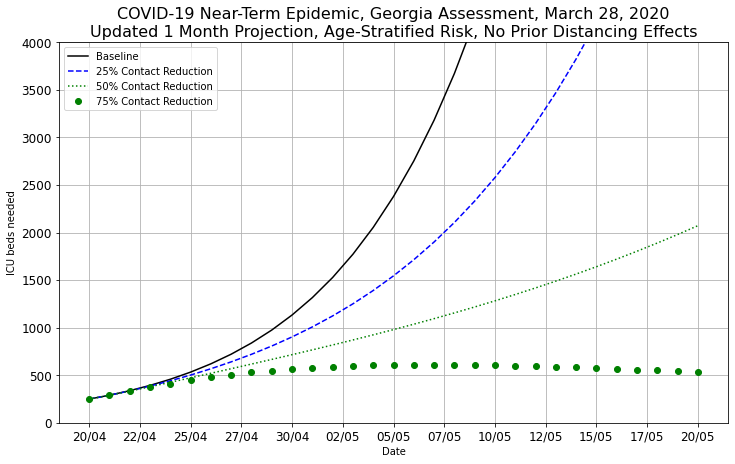

In [18]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.plot(dates, Hacu[0], 'k', label = "Baseline")
ax.plot(dates, Hacu[1], 'b--', label = "25% Contact Reduction")
ax.plot(dates, Hacu[2], 'g:', label = "50% Contact Reduction")
ax.plot(dates, Hacu[3], 'go', label = "75% Contact Reduction")
ax.set(xlabel = 'Date', ylabel = 'ICU beds needed', ylim = (0, 4000))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""COVID-19 Near-Term Epidemic, Georgia Assessment, March 28, 2020
Updated 1 Month Projection, Age-Stratified Risk, No Prior Distancing Effects""")
plt.show()

## Cummulative symptomatic cases

In [19]:
fracI = [f[tmpi] * (1 - pp.population["overall_p"]) * pp.population["N"] for f in stats["fracI"]]

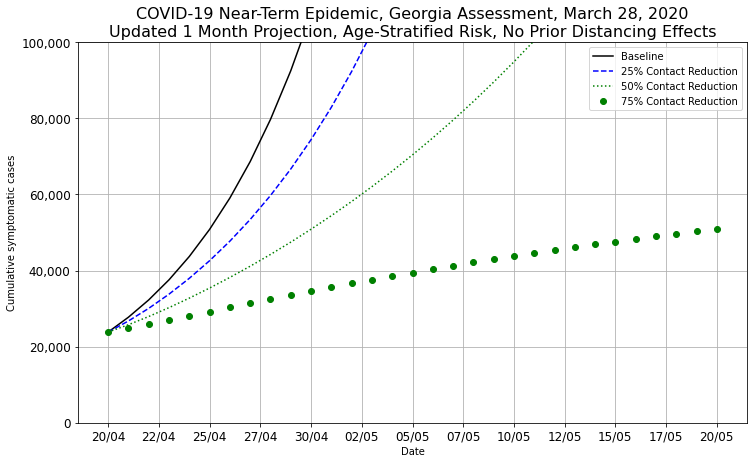

In [20]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.plot(dates, fracI[0], 'k', label = "Baseline")
ax.plot(dates, fracI[1], 'b--', label = "25% Contact Reduction")
ax.plot(dates, fracI[2], 'g:', label = "50% Contact Reduction")
ax.plot(dates, fracI[3], 'go', label = "75% Contact Reduction")
ax.set(xlabel = 'Date', ylabel = 'Cumulative symptomatic cases', ylim = (0, 1e5))
ax.xaxis.set_major_formatter(date_form)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""COVID-19 Near-Term Epidemic, Georgia Assessment, March 28, 2020
Updated 1 Month Projection, Age-Stratified Risk, No Prior Distancing Effects""")
plt.show()